# Bayesian Neural Network Win Probability for NCAA Basketball

## Evan Zamir

![Man staring into abyss](img/jakub-kriz-arOyDPUAJzc-unsplash.jpg)

About a year ago I wrote a post on [modeling win probability for basketball](https://medium.com/analytics-vidhya/a-simple-neural-network-for-in-game-win-probability-modeling-of-ncaa-basketball-games-58ab4e3ca0f9) using a neural network approach. As a reminder, win probability models attempt to predict the eventual outcome during the course of a game using features such as prior team ratings (eg point spread), current lead, and time remaining. For example, two evenly matched teams on a neutral court at the start of a game will each have about 50% chance of winning the game, while a heavy favorite that is up by 6 points with 8 seconds left in the second half will win, say, 99% of the time or thereabouts. Every approach I've seen to modeling win probability, including my own, outputs point estimates without regard to uncertainty therein. Since I've been on somewhat of a Bayesian kick recently, I thought it would be useful (for me, but hopefully you too!) to update my previous attempt at a WP model by making it, well, Bayesian. And to do that, as in all my recent projects, I will be using [Uber's open-source probabilistic programming library called Pryo](http://pyro.ai/). In this post I'll walk you through how to create a Bayesian neural network in Pyro, and show some of the neat features that come out of it, as well as some interesting (I hope) results. Let's go!

As always, we start with some imports...

In [1]:
import bz2
import json
import os
import warnings

import torch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from torch.distributions import constraints
from torch import nn
from IPython import display
import pyro
from pyro.nn import PyroModule, PyroSample
import pyro.distributions as dist
import pyro.optim as optim
from pyro.infer.autoguide import AutoDiagonalNormal
from pyro.infer import SVI, Trace_ELBO, Predictive

from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import train_test_split

pyro.set_rng_seed(1)
assert pyro.__version__.startswith('1.5.0')
%matplotlib inline
warnings.simplefilter('ignore')
pd.set_option('display.max_columns', None)

Then we read in the dataset, which I acquired from scraping publicly available NCAA play-by-play data (feel free to play around with the data which is included in the github repo). I've turned periods into categorical variables, which will be used as features in the model as you'll see shortly. I am also splitting the data into train and test sets. 

In [103]:
df = pd.read_csv('data/wp_prob_data_dec20.csv').sample(frac=1.0)
df = df.drop_duplicates()
df['lead'] = df['home']-df['visitor']
period_dummies = pd.get_dummies(df.period, prefix='p', prefix_sep='_') # turn periods into categorical variables
df = pd.concat([df, period_dummies],axis=1)
df['total_pts'] = df.home + df.visitor
train_id, test_id = train_test_split(list(df.game_id.unique()), test_size=0.1)
train = df[df.game_id.isin(train_id)]
test = df[df.game_id.isin(test_id)]
print(f'{len(train_id)} games used for training. {len(test_id)} games used for testing.')
train.head()

4863 games used for training. 541 games used for testing.


,game_id,season,home_team,away_team,net_ortg,net_drtg,clock,period,home,visitor,total_time_minutes,sec_rem_period,total_seconds_elapsed,win,lead,p_1,p_2,p_3,p_4,p_5,p_6,total_pts
14392,401183194,2020,Colorado,Iona,7.5,-12.7,00:04:37,2,90,46,40,277,2123,1,44,0,1,0,0,0,0,136
503410,401172071,2020,Coppin State,Rider,-11.3,3.2,00:13:44,1,15,6,40,824,376,0,9,1,0,0,0,0,0,21
58229,401173608,2020,Missouri State,Murray State,2.4,0.9,00:14:33,1,4,4,40,873,327,1,0,1,0,0,0,0,0,8
1130436,401176486,2020,Sacred Heart,St. Francis (PA),-5.4,-3.1,00:15:48,1,2,3,40,948,252,0,-1,1,0,0,0,0,0,5
1376165,401176311,2020,Arkansas-Pine Bluff,Prairie View A&M,-17.3,4.1,00:11:58,1,14,12,40,718,482,0,2,1,0,0,0,0,0,26


Now we'll define the neural network model with 3 hidden layers. This is an extremely simple architecture (not "deep learning"!), but the interesting feature here is obviously that we model the connecting weights as probability distributions (using Normal priors). This is how we can inject and model uncertainty.

In [4]:
class ThreeLayerNNModel(PyroModule):
    def __init__(self, in_features, out_features, h1, h2, h3):
        super().__init__()
        self.fc1 = PyroModule[nn.Linear](in_features, h1)
        self.fc1.weight = PyroSample(dist.Normal(0., 1.).expand([h1, in_features]).to_event(2))
        self.fc1.bias = PyroSample(dist.Normal(0., 10.).expand([h1]).to_event(1))
        self.fc2 = PyroModule[nn.Linear](h1, h2)
        self.fc2.weight = PyroSample(dist.Normal(0., 1.).expand([h2, h1]).to_event(2))
        self.fc2.bias = PyroSample(dist.Normal(0., 10.).expand([h2]).to_event(1))
        self.fc3 = PyroModule[nn.Linear](h2, h3)
        self.fc3.weight = PyroSample(dist.Normal(0., 1.).expand([h3, h2]).to_event(2))
        self.fc3.bias = PyroSample(dist.Normal(0., 10.).expand([h3]).to_event(1))
        self.fc4 = PyroModule[nn.Linear](h3, out_features)
        self.fc4.weight = PyroSample(dist.Normal(0., 1.).expand([out_features, h3]).to_event(2))
        self.fc4.bias = PyroSample(dist.Normal(0., 10.).expand([out_features]).to_event(1))
        self.sigmoid = nn.Sigmoid()
        self.relu = nn.ReLU()

    def forward(self, x, y=None):
        x1 = self.relu(self.fc1(x).squeeze(-1))
        x2 = self.relu(self.fc2(x1).squeeze(-1))
        x3 = self.relu(self.fc3(x2).squeeze(-1))
        p = self.sigmoid(self.fc4(x3).squeeze(-1))
        with pyro.poutine.scale(scale=len(train)/len(x)):
            obs = pyro.sample("obs", dist.Bernoulli(p), obs=y)
        return p

One very technical note here is that the context manager I'm using here is `pyro.poutine.scale`, instead of `pyro.plate`, which I've used in all my previous Pyro projects to date. I did this based on [recommendation from the Pyro discussion forum](https://forum.pyro.ai/t/confused-how-to-implement-simple-bayesian-nn/2443), and even though it is still not clear to me exactly why this is needed, I can tell you that it definitely is needed, as I had no luck using the `plate`. Assuming I eventually do figure out the implementation details, I will update this project. By all means, if you have some insight, let me know! At any rate, the rest of the code should be fairly self-explanatory. 

As always, once the model is defined, we can then move on to inference (eg training) using the black-box stochastic variational inference (SVI) feature that makes Pyro super easy to use for a novice. Because all the priors on the model are Normal distributions, the `AutoDiagonalNormal` guide which assumes independent normals should work well here. One thing I'm doing differently here than in my previous posts is using Torch's `DataLoader` class to train the model using mini-batches, as opposed to using Pyro's own `plate` sub-sampling. 

In [5]:
def inference(model, features=None, batch_size=1000, lr=0.001, epochs=10):
    pyro.clear_param_store()
    guide = AutoDiagonalNormal(model)
    adam = pyro.optim.Adam({"lr": lr})
    svi = SVI(model, guide, adam, loss=Trace_ELBO())
    x_train = torch.from_numpy(train[features].to_numpy().squeeze()).float()
    y_train = torch.from_numpy(train['win'].to_numpy().squeeze()).float()
    num_samples = len(y_train)
    dataset = torch.utils.data.TensorDataset(x_train, y_train)
    train_loader = torch.utils.data.DataLoader(dataset=dataset,
            batch_size=batch_size, shuffle=True)

    losses = []
    loss = 0
    epoch_loss = 0
    for epoch in range(epochs):
        for i,(xiter, yiter) in enumerate(train_loader):
            loss = svi.step(xiter, yiter)
            if i%(round(num_samples/batch_size/10))==0:
                losses.append(loss/batch_size)
                print(f"*",end=' ')
        print(f"epoch {epoch+1}: {loss/batch_size}")
    return losses, guide

We can then train the model using whatever features we think can be useful. Here I'm going to feed it the `net_ortg` and `net_drtg` (according to [kenpom](http://kenpom.com)), which serve as team prior ratings, in addition to `lead`, seconds remaining in the current period (`sec_rem_period`), the total points scored by both teams (`total_pts`), and as mentioned earlier a dummy variable representing the current period `p_n (n=1..6)`. In the code below, I'm setting the number of nodes in each hidden layer to 24.

* * * * * * * * * * * epoch 1: 5251.80798961401
* * * * * * * * * * * epoch 2: 1427.8104579758644
* * * * * * * * * * * epoch 3: 928.1242354912758
* * * * * * * * * * * epoch 4: 742.7419070935249
* * * * * * * * * * * epoch 5: 562.3380311889648
* * * * * * * * * * * epoch 6: 621.596552444458
* * * * * * * * * * * epoch 7: 621.7000702347756
* * * * * * * * * * * epoch 8: 530.2387003159523
* * * * * * * * * * * epoch 9: 496.064912651062
* * * * * * * * * * * epoch 10: 498.21219242954254
* * * * * * * * * * * epoch 11: 397.0304953789711
* * * * * * * * * * * epoch 12: 497.91583234739306
* * * * * * * * * * * epoch 13: 450.96466639518735
* * * * * * * * * * * epoch 14: 445.39733984708784
* * * * * * * * * * * epoch 15: 421.1597706027031
* * * * * * * * * * * epoch 16: 408.53433115911486
* * * * * * * * * * * epoch 17: 441.59179869890215
* * * * * * * * * * * epoch 18: 389.1922199344635
* * * * * * * * * * * epoch 19: 426.6170661277771
* * * * * * * * * * * epoch 20: 424.55558036708834


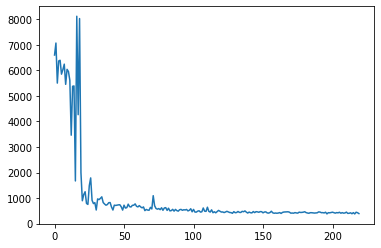

In [104]:
features = ['net_ortg','net_drtg','lead','sec_rem_period','total_pts', 'p_1','p_2','p_3','p_4','p_5','p_6']
model = ThreeLayerNNModel(11, 1, 24, 24, 24)
losses, guide = inference(model, features=features, epochs=20)
plt.plot(losses)

Next we define a couple of helper functions to sample from the posterior predictions and make some pretty win probability plots.

In [136]:
def summary(samples):
    site_stats = {}
    for k, v in samples.items():
        site_stats[k] = {
            "mean": torch.mean(v, 0),
            "std": torch.std(v, 0),
            "5%": v.kthvalue(int(len(v) * 0.05), dim=0)[0],
            "95%": v.kthvalue(int(len(v) * 0.95), dim=0)[0],
        }
    return site_stats

def plot_wp(game_id, model, guide, num_samples=1000, legend_loc='upper right', features=None):
    guide.requires_grad_(False)
    game = df[df.game_id==game_id].sort_values(by='total_seconds_elapsed',ascending=False)
    deltas = game.lead.diff()
    lead_changes = []
    for index, value in deltas.iteritems():
        if abs(value)>0:
            lead_changes.append(index)
    lead_change_df = game[game.index.isin(lead_changes)].sort_values('total_seconds_elapsed',ascending=True)[['lead','total_seconds_elapsed']]
    x_test = torch.from_numpy(game[features].to_numpy().squeeze()).float()
    predictive = Predictive(model, guide=guide, num_samples=num_samples, return_sites=("obs","_RETURN"))
    samples = predictive(x_test)
    game_summary = summary(samples)

    fig = plt.figure(figsize=(10,5))
    if max(game.win):
        plt.plot(game.total_seconds_elapsed/60,game_summary['_RETURN']['mean'],'b-',alpha=0.95,label=game.home_team.unique()[0])
        plt.plot(game.total_seconds_elapsed/60,game_summary['_RETURN']['5%'],'b:',alpha=0.35)
        plt.plot(game.total_seconds_elapsed/60,game_summary['_RETURN']['95%'],'b:',alpha=0.35)
        plt.text(game.total_seconds_elapsed/60,game_summary['_RETURN']['mean'],str(game.home))
        for index, row in lead_change_df.iterrows():
            plt.text(row.total_seconds_elapsed/60, 0.5+0.3*row.lead/abs(lead_change_df.min().lead-lead_change_df.max().lead), row.lead,fontdict={'size':8,'color':'green'})
    else:
        plt.plot(game.total_seconds_elapsed/60,1-game_summary['_RETURN']['mean'],'b-',alpha=0.95,label=game.away_team.unique()[0])
        plt.plot(game.total_seconds_elapsed/60,1-game_summary['_RETURN']['5%'],'b:',alpha=0.35)
        plt.plot(game.total_seconds_elapsed/60,1-game_summary['_RETURN']['95%'],'b:',alpha=0.35)
        for index, row in lead_change_df.iterrows():
            plt.text(row.total_seconds_elapsed/60, 0.5-0.3*row.lead/abs(lead_change_df.min().lead-lead_change_df.max().lead), -row.lead,fontdict={'size':8,'color':'green'})
    plt.ylim(0,1)
    plt.grid(True,which='both',alpha=0.5)
    plt.xlabel('Time Elapsed (Min)')
    plt.ylabel('Win Probability')
    plt.title(f'{game.home_team.unique()[0]} {max(game.home)} - {game.away_team.unique()[0]} {max(game.visitor)} ({game_id})')
    plt.legend(loc=legend_loc)
#     plt.savefig(f'{game_id}.png')

In [107]:
train[train.game_id==401260005]

,game_id,season,home_team,away_team,net_ortg,net_drtg,clock,period,home,visitor,total_time_minutes,sec_rem_period,total_seconds_elapsed,win,lead,p_1,p_2,p_3,p_4,p_5,p_6,total_pts
1639556,401260005,2021,Duke,Michigan State,-1.4,-2.8,00:04:17,1,27,24,40,257,943,0,3,1,0,0,0,0,0,51
1639579,401260005,2021,Duke,Michigan State,-1.4,-2.8,00:01:54,1,31,31,40,114,1086,0,0,1,0,0,0,0,0,62
1639615,401260005,2021,Duke,Michigan State,-1.4,-2.8,00:17:20,2,36,48,40,1040,1360,0,-12,0,1,0,0,0,0,84
1639488,401260005,2021,Duke,Michigan State,-1.4,-2.8,00:11:21,1,15,7,40,681,519,0,8,1,0,0,0,0,0,22
1639711,401260005,2021,Duke,Michigan State,-1.4,-2.8,00:05:43,2,51,62,40,343,2057,0,-11,0,1,0,0,0,0,113
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1639683,401260005,2021,Duke,Michigan State,-1.4,-2.8,00:09:12,2,45,58,40,552,1848,0,-13,0,1,0,0,0,0,103
1639428,401260005,2021,Duke,Michigan State,-1.4,-2.8,00:18:33,1,3,0,40,1113,87,0,3,1,0,0,0,0,0,3
1639575,401260005,2021,Duke,Michigan State,-1.4,-2.8,00:02:19,1,31,31,40,139,1061,0,0,1,0,0,0,0,0,62
1639602,401260005,2021,Duke,Michigan State,-1.4,-2.8,00:18:52,2,33,42,40,1132,1268,0,-9,0,1,0,0,0,0,75


Let's look at the [Michigan St. vs. Duke game from Dec 1](https://www.espn.com/mens-college-basketball/game?gameId=401260005):

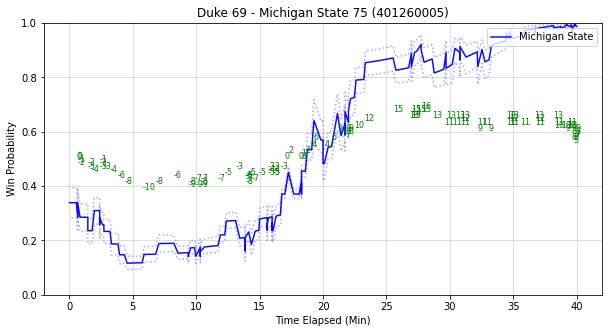

In [109]:
plot_wp(401260005, model, guide, features=features)

The green numbers in the plot represent leads for the home team (Duke) at various time points during the game. The dotted blue lines represent the 90% confidence interval from 5% to 95%. For reference, here is what the WP chart looks like according to ESPN:

![](img/msu-duke-wp.png)

Fairly similar but with some uncertainty estimates! It's interesting to look at the distributions as we vary various features. For example, let's look at a hypothetical matchup of two evenly matched teams (0 net off and def ratings) with 10 seconds remaining in the game as a function of the lead:

In [119]:
guide.requires_grad_(False)
ptups = {}
net_ortg = 0
net_drtg = 0
seconds_remain = 10
total_points = 150
for lead in np.arange(-6,7):
    x = torch.Tensor([net_ortg,net_drtg,lead,seconds_remain,total_points,0,1,0,0,0,0])
    predictive = Predictive(model, guide=guide, num_samples=1000, return_sites=("obs","_RETURN"))
    predictions = predictive(x)
    ptups[lead] = [float(p) for p in predictions['_RETURN']]
ptups_df = pd.DataFrame.from_dict(ptups)
pred_df = pd.melt(ptups_df,var_name='lead',value_name='prediction')
pred_df.sample(frac=0.01).head(10)

,lead,prediction
1131,-5,0.039282
579,-6,0.007430
3746,-3,0.067052
660,-6,0.015247
2916,-4,0.031446
6229,0,0.487279
5348,-1,0.318605
8418,2,0.873279
8433,2,0.880665
4240,-2,0.092239


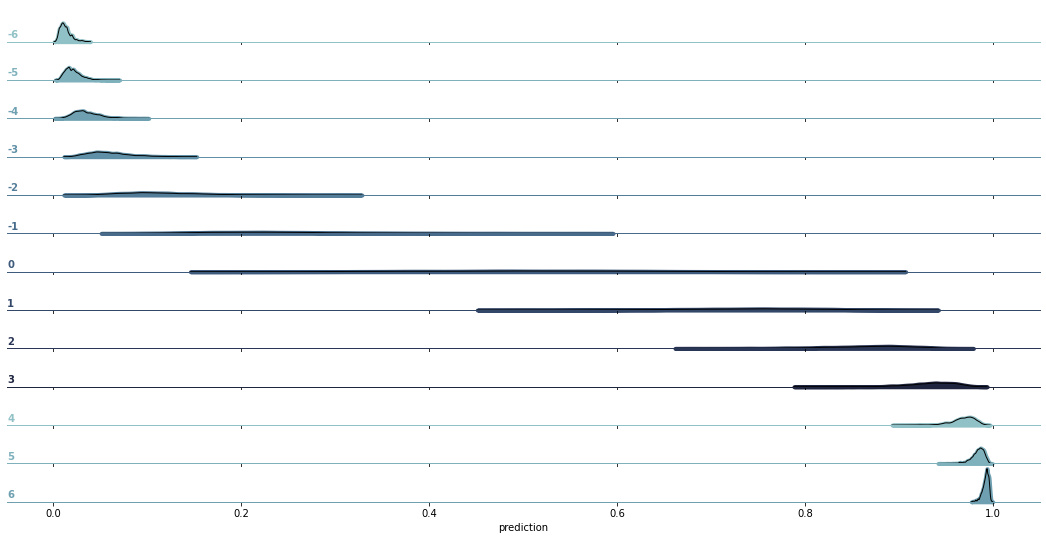

In [120]:
# this code is straight out of the Seaborn gallery

def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes)
    
pal = sns.cubehelix_palette(10, rot=-.25, light=.7)
g = sns.FacetGrid(data=pred_df,row='lead',hue='lead',aspect=25,height=0.6,palette=pal)
g.map(sns.kdeplot, "prediction",
      bw_adjust=.5, clip_on=False,
      fill=True, alpha=1, linewidth=4)
g.map(sns.kdeplot, "prediction", color="k", lw=1, bw_adjust=0.5)
g.map(plt.axhline, y=0, lw=1, clip_on=False)
g.map(label, "prediction")

# Set the subplots to overlap
g.fig.subplots_adjust(hspace=0.1)

g.set_titles("")
g.set(yticks=[])
g.despine(bottom=True, left=True)

So that's pretty neat. We see that the predictions are much more certain (ie narrow) as the lead increases both ways, whereas at a lead of 0 the distribution is very wide (with a slight advantage to the home team as one would expect). Let's try this again, but now we'll look at the effect of changing the time remaining while keeping the lead constant at 4 points (for the home team):

In [126]:
guide.requires_grad_(False)
ptups = {}
net_ortg = 0
net_drtg = 0
lead = 4
total_points = 150
for seconds_remain in np.arange(120,-10,-10):
    x = torch.Tensor([net_ortg,net_drtg,lead,seconds_remain,total_points,0,1,0,0,0,0])
    predictive = Predictive(model, guide=guide, num_samples=1000, return_sites=("obs","_RETURN"))
    predictions = predictive(x)
    ptups[seconds_remain] = [float(p) for p in predictions['_RETURN']]
ptups_df = pd.DataFrame.from_dict(ptups)
pred_df = pd.melt(ptups_df,var_name='seconds_remain',value_name='prediction')
pred_df.sample(frac=0.01).head(10)

,seconds_remain,prediction
8318,40,0.970998
4482,80,0.918849
6850,60,0.965420
5693,70,0.943385
6201,60,0.927877
8279,40,0.938761
8395,40,0.964576
7430,50,0.911416
10428,20,0.971629
11140,10,0.976143


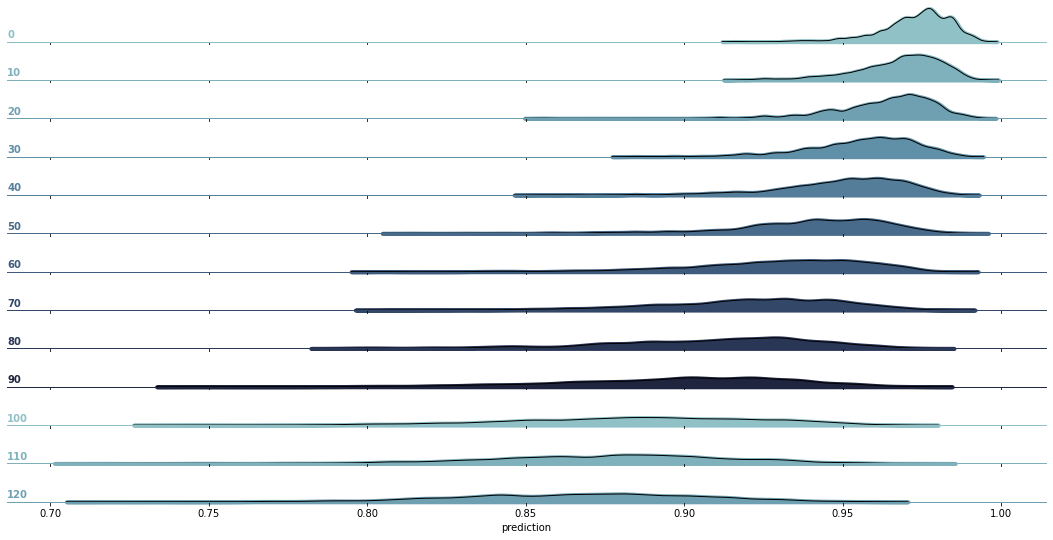

In [127]:
# this code is straight out of the Seaborn gallery

def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes)
    
pal = sns.cubehelix_palette(10, rot=-.25, light=.7)
g = sns.FacetGrid(data=pred_df,row='seconds_remain',hue='seconds_remain',aspect=25,height=0.6,palette=pal)
g.map(sns.kdeplot, "prediction",
      bw_adjust=.5, clip_on=False,
      fill=True, alpha=1, linewidth=4)
g.map(sns.kdeplot, "prediction", color="k", lw=1, bw_adjust=0.5)
g.map(plt.axhline, y=0, lw=1, clip_on=False)
g.map(label, "prediction")

# Set the subplots to overlap
g.fig.subplots_adjust(hspace=0.1)

g.set_titles("")
g.set(yticks=[])
g.despine(bottom=True, left=True)

Once again we see how the distributions shrink in a way that makes sense intuitively as time goes to zero. Interestingly, the model does not "know" that at the end of the game the team with the lead has 100% chance of winning. I suspect this is an issue with the play-by-play data not having events occuring with 0 seconds remaining. Perhaps, I need to add some "fake" end of game event.

So now that we got the feel of the model, let's do some validation. First, I want to look at performance on the test set using two measures,  cross entropy (or logistic loss) and AUC. To do this, we first need to sample from the posterior:

In [128]:
def eval_test(test_df, guide, features=None, num_samples=1000):
    x_test = torch.from_numpy(test_df[features].to_numpy().squeeze()).float()
    predictive = Predictive(model, guide=guide, num_samples=num_samples, return_sites=("obs","_RETURN"))
    samples = predictive(x_test)
    return summary(samples)

In [129]:
test_summary = eval_test(test, guide, features)
print(test_summary)

{'obs': {'mean': tensor([0.1750, 0.9500, 0.9930,  ..., 0.9420, 0.9880, 0.9980]), 'std': tensor([0.3802, 0.2181, 0.0834,  ..., 0.2339, 0.1089, 0.0447]), '5%': tensor([0., 0., 1.,  ..., 0., 1., 1.]), '95%': tensor([1., 1., 1.,  ..., 1., 1., 1.])}, '_RETURN': {'mean': tensor([0.1910, 0.9406, 0.9956,  ..., 0.9462, 0.9849, 0.9979]), 'std': tensor([0.0255, 0.0268, 0.0019,  ..., 0.0107, 0.0046, 0.0014]), '5%': tensor([0.1520, 0.8901, 0.9917,  ..., 0.9272, 0.9765, 0.9953]), '95%': tensor([0.2371, 0.9738, 0.9982,  ..., 0.9629, 0.9914, 0.9993])}}


In [130]:
test['p_mean'] = test_summary['_RETURN']['mean']
test['5%'] = test_summary['_RETURN']['5%']
test['95%'] = test_summary['_RETURN']['95%']
test.head()

,game_id,season,home_team,away_team,net_ortg,net_drtg,clock,period,home,visitor,total_time_minutes,sec_rem_period,total_seconds_elapsed,win,lead,p_1,p_2,p_3,p_4,p_5,p_6,total_pts,p_mean,5%,95%
116845,401168409,2020,Kansas State,Marquette,-11.5,-2.7,00:09:51,1,8,14,40,591,609,0,-6,1,0,0,0,0,0,22,0.190956,0.151974,0.237107
53320,401172064,2020,Fairleigh Dickinson,Quinnipiac,1.4,4.1,00:02:35,1,38,22,40,155,1045,1,16,1,0,0,0,0,0,60,0.940619,0.890136,0.973751
1262917,401174847,2020,Texas State,Arkansas State,2.1,-9.2,00:03:13,2,60,49,40,193,2207,1,11,0,1,0,0,0,0,109,0.995610,0.991661,0.998185
376309,401168165,2020,Virginia Tech,Coppin State,14.7,-7.3,00:14:29,1,16,3,40,869,331,1,13,1,0,0,0,0,0,19,0.997059,0.994388,0.998729
1437676,401175019,2020,North Dakota State,South Dakota State,-3.2,-4.1,00:00:33,2,58,58,45,33,2367,1,0,0,1,0,0,0,0,116,0.548832,0.443871,0.654479


In [131]:
def cross_entropy(ybar, y):
    return (-np.dot(y, np.log(ybar))-np.dot(1-y, 1-np.log(ybar)))/len(y)

y_test = torch.from_numpy(test['win'].to_numpy().squeeze())
ybar_test = torch.from_numpy(test['p_mean'].to_numpy().squeeze())
cross_entropy(ybar_test, y_test)

-0.8106595072375274

In [132]:
from sklearn.metrics import roc_auc_score
from sklearn import metrics

metrics.roc_auc_score(test.win, test.p_mean)

0.9010450278445731

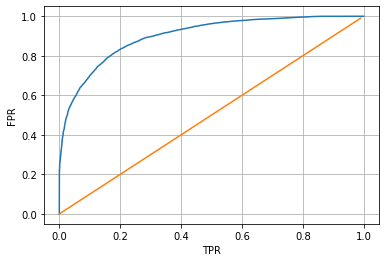

In [133]:
fpr, tpr, thresholds = metrics.roc_curve(test.win, test['p_mean'])
plt.plot(fpr, tpr)
plt.plot(np.arange(0,1,0.01),np.arange(0,1,0.01))
plt.xlabel('TPR')
plt.ylabel('FPR')
plt.grid()

The cross-entropy is useful if we want to compare different models, but alone is a bit obtuse. The AUC, on the other hand, is easy to interpret. Clearly, according to the AUC this is a pretty decent model. Another thing we want to check is how well the model is calibrated. This involves binning predictions and then checking if actual outcomes fall into the bins on average. For example, if the model outputs 80% probabilty of winning, then we expect on average 80% of the outcomes will be wins. If it is far away from this value on either side, something could be wrong. 

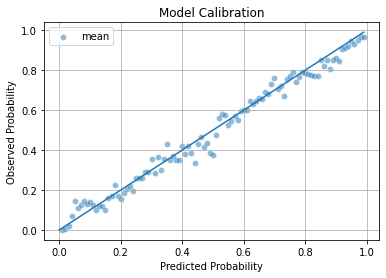

In [134]:
test['mean_bucket'] = pd.cut(test.p_mean, np.arange(0,1,0.01))
categories = test.mean_bucket.cat.categories
win_pct_bucket = test.groupby('mean_bucket').mean().win
cal_df_mean = pd.DataFrame.from_records(list(zip(categories.right, win_pct_bucket)),columns=['tick','pct'])
g = sns.scatterplot(data=cal_df_mean,x='tick',y='pct',label='mean',alpha=0.5).grid()
plt.plot(np.arange(0,1,0.01),np.arange(0,1,0.01))
plt.title('Model Calibration')
plt.xlabel('Predicted Probability')
plt.ylabel('Observed Probability')
plt.show()

The model appears to be well-calibrated, indeed!

That's about all I have for now. One thing that I am looking into is how to perform calibration for the confidence intervals I've shown here. It's not quite clear to me yet and, perhaps, not surprisingly, there doesn't appear to be a wellspring of information out there on how to do it. Before I leave you, let me share some more wp plots. And please leave a github star on this project, if you enjoyed it. And as always, you can reach out to me on Twitter (@thecity2) if you have questions or comments. Thanks!

In [139]:
df[df.game_id==401182629]

,game_id,season,home_team,away_team,net_ortg,net_drtg,clock,period,home,visitor,total_time_minutes,sec_rem_period,total_seconds_elapsed,win,lead,p_1,p_2,p_3,p_4,p_5,p_6,total_pts
603597,401182629,2020,Kansas,Dayton,-3.3,-8.6,00:00:14,1,36,37,45,14,1186,1,-1,1,0,0,0,0,0,73
603456,401182629,2020,Kansas,Dayton,-3.3,-8.6,00:17:48,1,6,9,45,1068,132,1,-3,1,0,0,0,0,0,15
603720,401182629,2020,Kansas,Dayton,-3.3,-8.6,00:01:58,2,69,66,45,118,2282,1,3,0,1,0,0,0,0,135
603786,401182629,2020,Kansas,Dayton,-3.3,-8.6,00:00:17,3,89,84,45,17,2683,1,5,0,0,1,0,0,0,173
603748,401182629,2020,Kansas,Dayton,-3.3,-8.6,00:03:55,3,76,75,45,235,2465,1,1,0,0,1,0,0,0,151
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
603614,401182629,2020,Kansas,Dayton,-3.3,-8.6,00:17:49,2,43,42,45,1069,1331,1,1,0,1,0,0,0,0,85
603753,401182629,2020,Kansas,Dayton,-3.3,-8.6,00:03:08,3,79,78,45,188,2512,1,1,0,0,1,0,0,0,157
603695,401182629,2020,Kansas,Dayton,-3.3,-8.6,00:06:59,2,60,66,45,419,1981,1,-6,0,1,0,0,0,0,126
603747,401182629,2020,Kansas,Dayton,-3.3,-8.6,00:03:55,3,75,75,45,235,2465,1,0,0,0,1,0,0,0,150


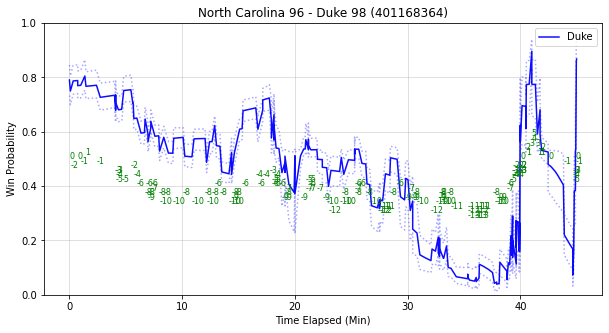

In [141]:
plot_wp(401168364, model, guide, features=features)

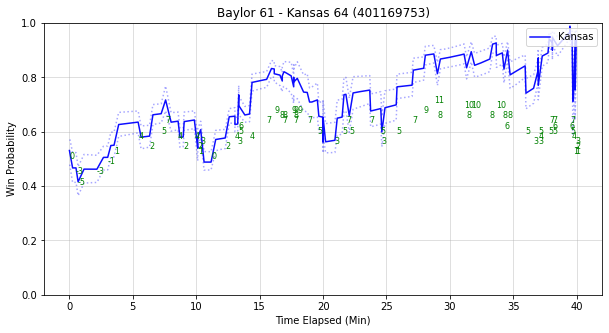

In [142]:
plot_wp(401169753, model, guide, features=features)

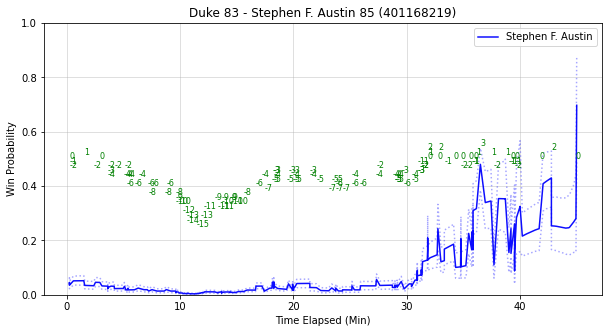

In [143]:
plot_wp(401168219, model, guide, features=features)

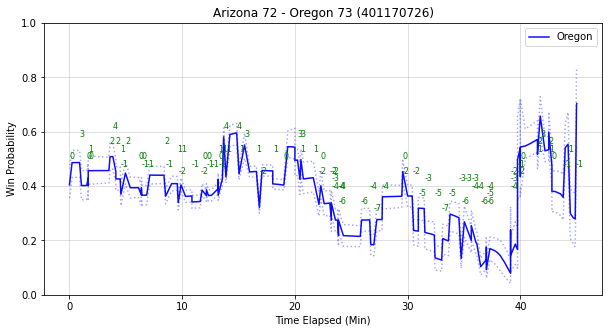

In [145]:
plot_wp(401170726, model, guide, features=features)